In [ ]:
import keras
from keras.models import Model
from keras.layers import *
import tensorflow as tf

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
IMAGE_SHAPE = (256, 256, 3)
BATCH_SIZE = 4
NUM_CLASSES = 32

# DATA

### Loading the Dataset

In [ ]:
!kaggle datasets download -d carlolepelaars/camvid
!unzip 'camvid.zip' -d 'Dataset'

In [5]:
class_dict = pd.read_csv(os.path.join('Dataset', 'CamVid', 'class_dict.csv'))
class_dict['Color'] = list(zip(class_dict['r'], class_dict['g'], class_dict['b']))
class_dict.drop(['r', 'g', 'b'], axis=1, inplace=True)
class_dict.head()

,name,Color
0,Animal,"(64, 128, 64)"
1,Archway,"(192, 0, 128)"
2,Bicyclist,"(0, 128, 192)"
3,Bridge,"(0, 128, 64)"
4,Building,"(128, 0, 0)"


In [6]:
COLOR_MAP = tf.constant(class_dict['Color'].tolist(), dtype=tf.uint8)

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_png(img, channels=3)  # Decode as a 3-channel image

    return tf.cast(tf.image.resize(img, IMAGE_SHAPE[:2], 'nearest'), tf.uint8)

def rgb_to_one_hot( mask):
        one_hot_mask = tf.zeros((IMAGE_SHAPE[0], IMAGE_SHAPE[1], NUM_CLASSES), dtype=tf.uint8)

        for index, row in class_dict.iterrows():
            # Find the index corresponding to the RGB tuple
            idx = index
            # Find the pixels in the RGB mask that match the current RGB tuple
            mask_indices = tf.reduce_all(tf.equal(mask, row['Color']), axis=-1)
            # Convert the mask_indices to a one-hot mask for the current class
            mask_indices_reshaped = tf.expand_dims(mask_indices, axis=-1)
            class_mask = tf.one_hot(idx, NUM_CLASSES, dtype=tf.uint8)
            # Update the one-hot encoded mask where mask_indices is True
            one_hot_mask = tf.where(mask_indices_reshaped, class_mask, one_hot_mask)

        return one_hot_mask

train_img_path = os.path.join('Dataset', 'CamVid', 'train')
train_mask_path = os.path.join('Dataset', 'CamVid', 'train_labels')
test_img_path = os.path.join('Dataset', 'CamVid', 'test')
test_mask_path = os.path.join('Dataset', 'CamVid', 'test_labels')
val_img_path = os.path.join('Dataset', 'CamVid', 'val')
val_mask_path = os.path.join('Dataset', 'CamVid', 'val_labels')

images = []
for filename in sorted(os.listdir(train_img_path)):
    image_path = os.path.join(train_img_path, filename)
    image = load_image(image_path)
    images.append(image)

masks = []
for filename in sorted(os.listdir(train_mask_path)):
    mask_path = os.path.join(train_mask_path, filename)
    mask = load_image(mask_path)
    masks.append(rgb_to_one_hot(mask))

for filename in sorted(os.listdir(test_img_path)):
    image_path = os.path.join(test_img_path, filename)
    image = load_image(image_path)
    images.append(image)

for filename in sorted(os.listdir(test_mask_path)):
    mask_path = os.path.join(test_mask_path, filename)
    mask = load_image(mask_path)
    masks.append(rgb_to_one_hot(mask))

test_images = []
for filename in sorted(os.listdir(val_img_path)):
    image_path = os.path.join(val_img_path, filename)
    image = load_image(image_path)
    test_images.append(image)

test_masks = []
for filename in sorted(os.listdir(val_mask_path)):
    mask_path = os.path.join(val_mask_path, filename)
    mask = load_image(mask_path)
    test_masks.append(rgb_to_one_hot(mask))

train = tf.data.Dataset.from_tensor_slices((images, masks)).shuffle(600).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).shuffle(300).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
len(train), len(test), train, test

(151,
 25,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 256, 256, 32), dtype=tf.uint8, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 256, 256, 32), dtype=tf.uint8, name=None))>)

### Testing the Dataset

In [8]:
def one_hot_to_rgb(mask):
    class_indices = tf.expand_dims(tf.argmax(mask, axis=-1), axis=-1)

    rgb_mask = tf.squeeze(tf.cast(tf.gather(COLOR_MAP, class_indices, axis=0), tf.uint8), axis=2)
    return rgb_mask

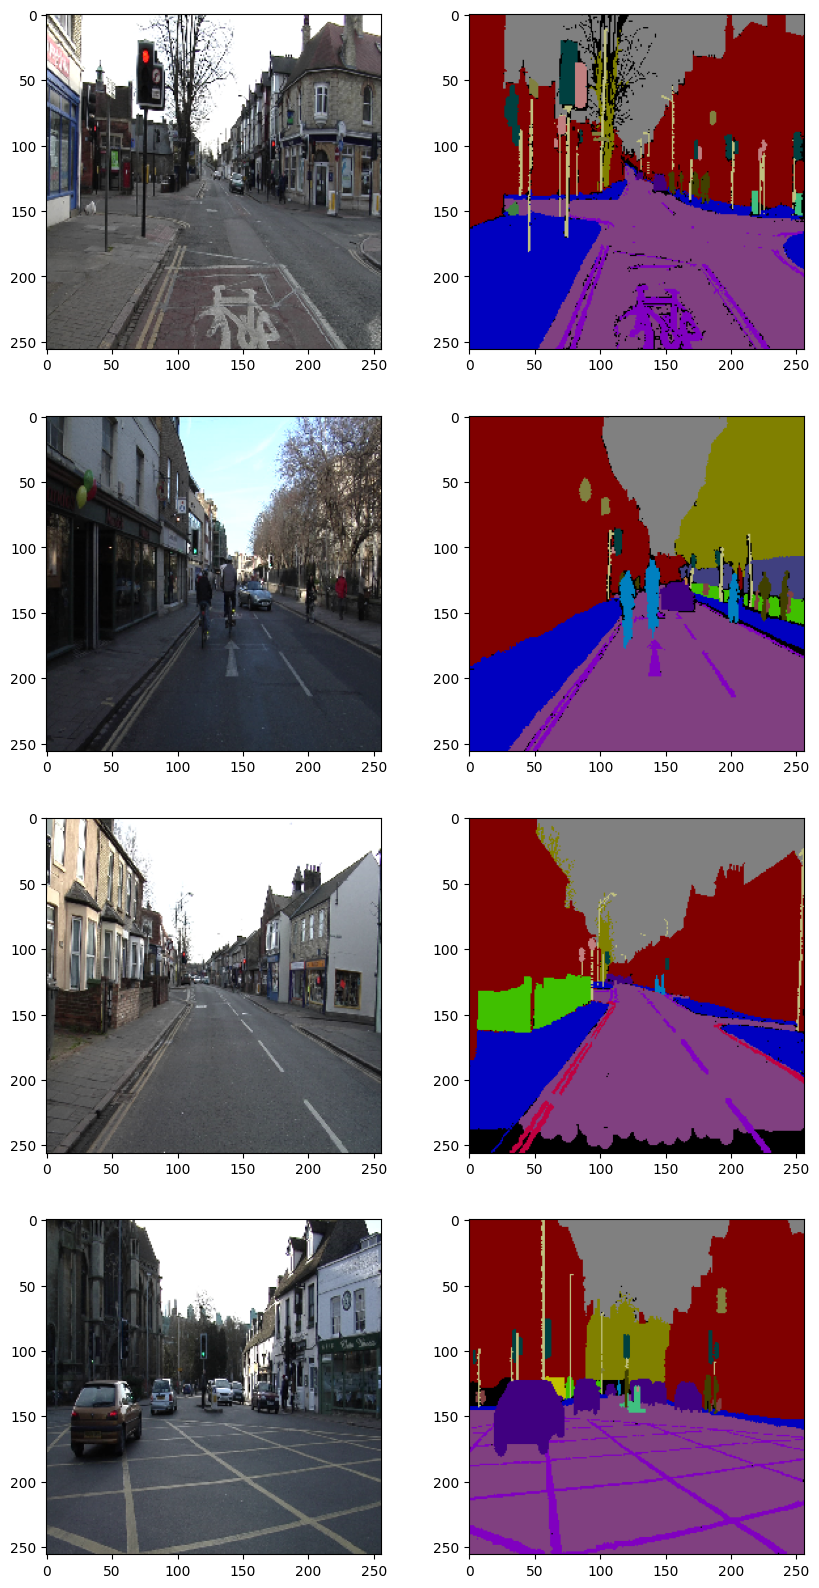

In [9]:
sample = test.as_numpy_iterator().next()

fig, ax = plt.subplots(4, 2, figsize=(10, 20))
for i in range(4):
    ax[i][0].imshow(sample[0][i])
    ax[i][1].imshow(one_hot_to_rgb(sample[1][i]))

# MODEL

### Building the Model

In [10]:
class UNetPlusPlus(Model):
    def __init__(self):
        super(UNetPlusPlus, self).__init__()

        self.augmentor = self.build_augmentor()
        self.model = self.build_model()


    # Augmentor to apply data augmentation on dataset
    def build_augmentor(self):
        seed = 42
        input_img = Input(IMAGE_SHAPE)
        input_mask = Input((IMAGE_SHAPE[0], IMAGE_SHAPE[1], NUM_CLASSES))

        img = RandomFlip("horizontal", seed=seed)(input_img)
        mask = RandomFlip("horizontal", seed=seed)(input_mask)

        img = RandomRotation(0.1, 'nearest', 'nearest', seed)(img)
        mask = RandomRotation(0.1, 'nearest', 'nearest', seed)(mask)

        img = RandomContrast(0.2)(img)
        img = RandomBrightness(factor=0.2)(img)
        img = GaussianNoise(0.2)(img)
        img = Resizing(IMAGE_SHAPE[0], IMAGE_SHAPE[1], "nearest")(img)
        out_img = Rescaling(1./255.)(img)

        mask = Resizing(IMAGE_SHAPE[0], IMAGE_SHAPE[1], "nearest")(mask)
        out_mask = tf.cast(mask, tf.uint8)

        return Model(inputs=[input_img, input_mask], outputs=[out_img, out_mask])

    # UNet++
    def build_model(self):
        def double_conv(filters, input):
            x = Conv2D(filters, 3, padding="same", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))(input)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)

            x = Conv2D(filters, 3, padding="same", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05))(x)
            x = BatchNormalization()(x)
            return Activation("relu")(x)


        inputs = Input(IMAGE_SHAPE)

        # Encoder
        x00 = double_conv(64, inputs)

        x10 = MaxPool2D()(x00)
        x10 = double_conv(128, x10)

        x20 = MaxPool2D()(x10)
        x20 = double_conv(256, x20)

        x30 = MaxPool2D()(x20)
        x30 = double_conv(512, x30)

        x40 = MaxPool2D()(x30)
        x40 = double_conv(1024, x40)

        #Decoder
        x31 = UpSampling2D()( x40)
        x31 = Concatenate()([x31, x30])
        x31 = double_conv(512, x31)

        x21 = UpSampling2D()( x30)
        x21 = Concatenate()([x21, x20])
        x21 = double_conv(256, x21)

        x11 = UpSampling2D()(x20)
        x11 = Concatenate()([x11, x10])
        x11 = double_conv(128, x11)

        x01 = UpSampling2D()(x10)
        x01 = Concatenate()([x01, x00])
        x01 = double_conv(64, x01)

        x22 = UpSampling2D()( x31)
        x22 = Concatenate()([x22, x21, x20])
        x22 = double_conv(256, x22)

        x12 = UpSampling2D()(x21)
        x12 = Concatenate()([x12, x11, x10])
        x12 = double_conv(128, x12)

        x02 = UpSampling2D()(x11)
        x02 = Concatenate()([x02, x01, x00])
        x02 = double_conv(64, x02)

        x13 = UpSampling2D()(x22)
        x13 = Concatenate()([x13, x12, x11, x10])
        x13 = double_conv(128, x13)

        x03 = UpSampling2D()(x12)
        x03 = Concatenate()([x03, x02, x01, x00])
        x03 = double_conv(64, x03)

        x04 = UpSampling2D()(x13)
        x04 = Concatenate()([x04, x03, x02, x01, x00])
        x04 = double_conv(64, x04)

        out = Conv2D(NUM_CLASSES, 1, padding="same", activation="softmax")(x04)

        return Model(inputs, out)

    def compile(self, loss_fn=None, opt=None, metric=None):
        super().compile()

        self.loss_fn = loss_fn
        self.optimizer = opt
        self.metric = metric

    # Custom train
    def train_step(self, data):
        images, masks = self.augmentor(data)        # Augmentation
        with tf.GradientTape() as tape:
            generated_masks = self.model(images, training=True)

            loss_val = self.loss_fn(masks, generated_masks)

        grads = tape.gradient(loss_val, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        self.metric.update_state(masks, generated_masks)

        result = {"loss":loss_val, "accuracy":self.metric.result()}
        return result


    # Custom test
    def test_step(self, data):
        images, masks = data
        images = tf.cast(images, tf.float32)/255.
        generated_masks = self.model(images, training=False)

        loss_val = self.loss_fn(masks, generated_masks)

        self.metric.update_state(masks, generated_masks)

        result = {"loss":loss_val, "accuracy":self.metric.result()}
        return result


    def call(self, inputs):
        return self.model(inputs)


    def save(self, path):
        self.model.save(path)

In [11]:
model = UNetPlusPlus()
model.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0]

### Training the Model

In [12]:
opt = tf.keras.optimizers.Adam(0.0003)
loss_func = tf.keras.losses.CategoricalFocalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()

model.compile(loss_func, opt, metric)

In [ ]:
model.fit(train, epochs=40, validation_data=test)

### Testing the Model

1/1 [==============================] - 0s 22ms/step


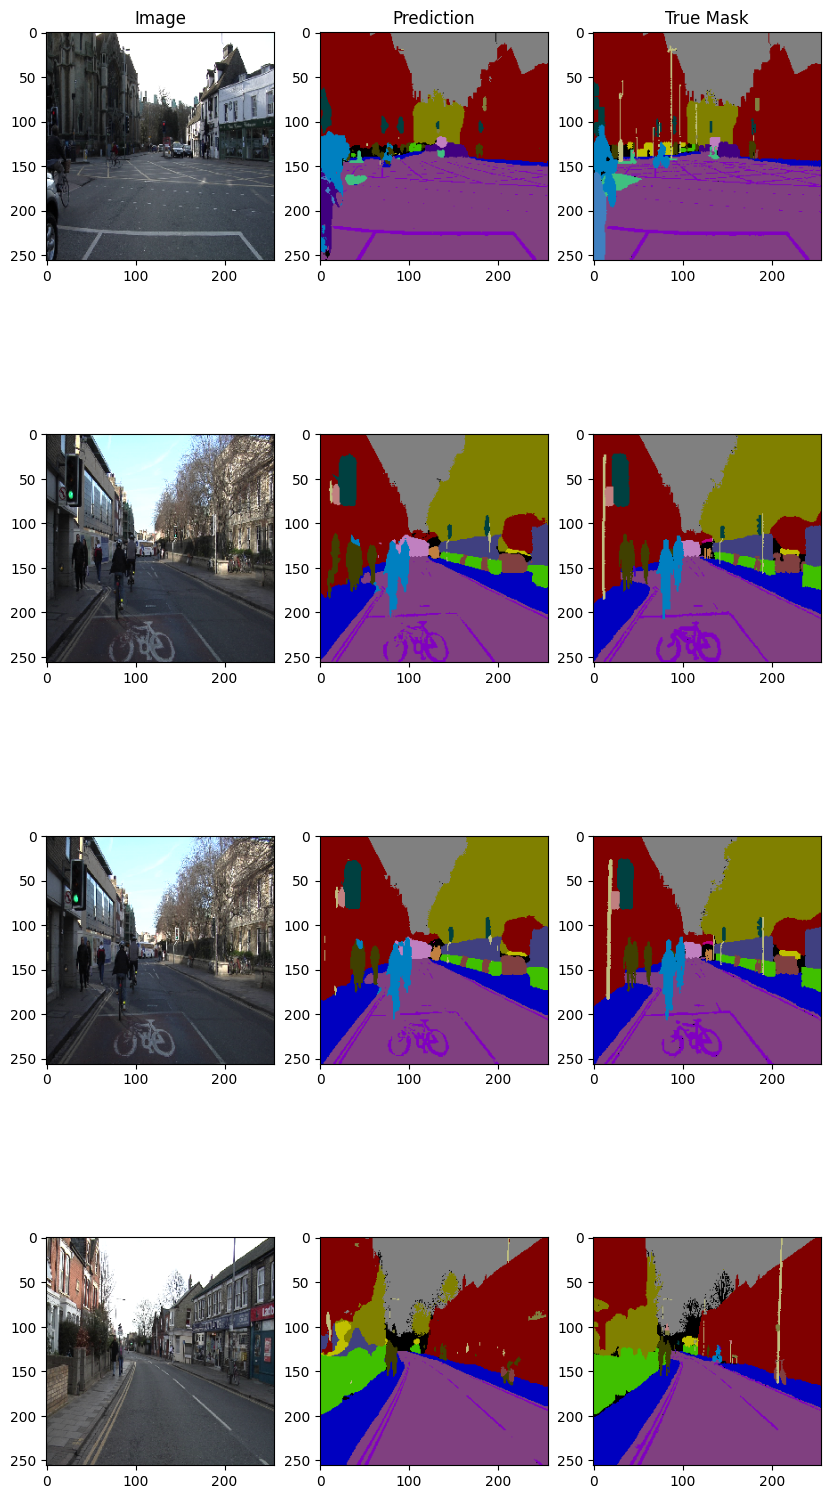

In [25]:
sample = test.as_numpy_iterator().next()
preds = model.predict(sample[0]/255.)

predicted_class_indices = tf.argmax(preds, axis=-1)
result = tf.one_hot(predicted_class_indices, depth=len(COLOR_MAP))

fig, ax = plt.subplots(4, 3, figsize=(10, 20))
ax[0, 0].set_title("Image")
ax[0, 1].set_title("Prediction")
ax[0, 2].set_title("True Mask")
for i in range(4):
    ax[i, 0].imshow(sample[0][i])
    ax[i, 1].imshow(one_hot_to_rgb(result[i]))
    ax[i, 2].imshow(one_hot_to_rgb(sample[1][i]))

### Saving the Model

In [17]:
model.save('U-Net++.h5')